## CAL HUC Data Backup

### Phase 2

### Cleanup and Reshape of Parsed Gloss Scrapes

Scrape Date: 4-21-2021 (Therefore Not Latest Version)

#### Introduction

In April 2021, a group of us, Assyrians, had a discussion about how the CAL HUC outreach sounds awfully pessimistic about its ability to continue operating its website. So we became highly concerned about losing it, since we used it regularly. The CAL database is invaluable. They spent ~40 years developing it, and it is a job well done. If I was a billionaire, then this project would be my first endowment focus.

What was supposed to happen was, as I imagine, we were supposed to come up with funds to donate; however, none of us were in that sort of position.

So I came up with a multi-phase plan to gracefully scrape as much of it as feasible. It does become somewhat of a maze, and I had to get back to other things — mainly work. But I managed to get through half the phases, grabbing the gloss pages (lists containing up to 48 word entries per page, with pronunciation and short English gloss) along with the URL to the full definition page of each entry.

#### Intent

This is meant to be an emergency backup. So it's not for redistribution; however, a backup is practically no good when it's in only one person's hands.

Note that this is a small part of their magnificent dataset.

#### Good Faith

All who have obtained access: please keep in private collections only.

#### Addendum

It's surprising that CAL only offers Latin transliterations. So (Eastern) Assyrian transliterations are added programmatically, in this phase. 

The latter is not expected to be reliable just yet. There will be many edge cases. Also, it would be good to add the Western dialect at some point. Probably easier to go from one Assyrian dialect to another, so one might wait until the Eastern dialect transliterations are reliable enough, then generate the Western equivalents.

I can do it fairly well by converting previous work from Kotlin to Python. I just have so much other work to do, especially nowadays. So if anyone wants to pick up on that task, then please do.

#### About

CAL stands for Comprehensive Aramaic Lexicon. HUC is the Hebrew Union College in Cincinnati, USA.

From the main webpage (cal.huc.edu):

> "The CAL is a text base of the Aramaic texts in all dialects from the earliest (9th Century BCE) through the 13th Century CE, currently with a database of approximately 3 million lexically parsed words, and an associated set of electronic tools for analyzing and manipulating the data, whose ultimate goal is the creation of a complete lexicon of the language. IT IS A WORK IN PROGRESS, not a completed dictionary. Accordingly, any citations for scholarly purposes should include the date when the data were found."


> "... The CAL has over 40,000 headwords, over 100,000 lexical citations, and literally millions of combinations in the way the database may be searched..."

For more info on who built this project and how, see the following: 
    
    cal.huc.edu/acknow.pdf

#### Good to have:

##### CAL Code - Prova

May or may not help in understanding notation in the data.

#### Setup

In [114]:
import sys
import codecs
import unicodedata
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Setup encoding so that Assyrian characters show and so they won't cause issues.

In [3]:
def set_encoding():
	if sys.stdout.encoding != 'UTF-8':
		sys.stdout = codecs.getwriter('utf-8')(sys.stdout.buffer, 'strict')

set_encoding()

By default, only some dataframe columns tend to be printed when there are many. We'll have it print all of them, so that we could see what's going on.

In [5]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)

Set initial variables.

In [7]:
# CSV delimiter
sep = ','

# filenames
base_filename = "cal_huc"
version = "0.1"
scrape_date = "20210421"
input_filename = f"{base_filename}_p_{scrape_date}_v{version}.csv"    # p - parsed
output_filename = f"{base_filename}_t_{scrape_date}_v{version}.csv"   # t - transliterated

Read the CSV file.

In [10]:
df = pd.read_csv(input_filename)

We don't want to print the entire `df`, since it might crash the browser/notebook. It could be done in a more powerful environment, though.

#### Quick Stats

Row length and unique column value counts:

In [12]:
df.describe()

,entry
count,314672.000000
mean,157336.500000
std,90838.126291
min,1.000000
25%,78668.750000
50%,157336.500000
75%,236004.250000
max,314672.000000


In [14]:
df.keys()

Index(['entry', 'trailing', 'lemma', 'vocal', 'class', 'gloss',
       'definition_url'],
      dtype='object')

In [16]:
len(df['entry'])

314672

In [18]:
len(df['trailing'].unique())

6978

In [20]:
len(df['lemma'].unique())

28443

In [22]:
len(df['vocal'].unique())

15246

In [24]:
len(df['class'].unique())

238

In [26]:
len(df['gloss'].unique())

21465

In [28]:
len(df['definition_url'].unique())

32183

#### Unique Characters

Get all the unique characters from the `trailing`, `lemma`, and `vocal` columns, so that we know what all needs to be converted from Latin to Assyrian.

In [30]:
def get_unique_characters(df, column='lemma'):
    # Concatenate all strings in the column
    all_text = ''.join(df[column].fillna('').astype(str))
    # Convert to set to get unique characters
    unique_chars = sorted(set(all_text))    
    # Create a DataFrame with characters and their Unicode values
    char_info = pd.DataFrame({
        'character': unique_chars,
        'unicode_value': [ord(c) for c in unique_chars]
    })
    # Add a column for human-readable Unicode names where possible
    try:
        import unicodedata
        char_info['unicode_name'] = [unicodedata.name(c, 'UNKNOWN') for c in char_info['character']]
    except ImportError:
        pass
    return char_info


def get_all_unique_characters(df, columns=['trailing', 'lemma', 'vocal']):
    all_text = ''.join(list([''.join(df[column].fillna('').astype(str)) for column in columns]))
    # Convert to set to get unique characters
    unique_chars = sorted(set(all_text))    
    # Create a DataFrame with characters and their Unicode values
    char_info = pd.DataFrame({
        'character': unique_chars,
        'unicode_value': [ord(c) for c in unique_chars]
    })
    # Add a column for human-readable Unicode names where possible
    try:
        import unicodedata
        char_info['unicode_name'] = [unicodedata.name(c, 'UNKNOWN') for c in char_info['character']]
    except ImportError:
        pass
    return char_info


def get_column_unique_chars(df, *columns):
    unique_chars = get_unique_characters(df, columns[0]) if len(columns) == 1 else get_all_unique_characters(df, columns)
    print(f"{len(unique_chars)} unique chars:\n{' '.join(unique_chars['character'].sort_values())}")
    return unique_chars['character']


def get_column_exclusive_unique_chars(target_list, *other_lists):
    """returns chars that are exclusive to `target_list`"""
    others_set = set([item for other_list in other_lists for item in other_list])
    return set(target_list) - others_set 

Unique characters in `trailing`, `lemma`, and `vocal` columns:

In [32]:
all_unique_chars = get_column_unique_chars(df, 'trailing', 'lemma', 'vocal')

99 unique chars:
  ! # $ ' ( ) * + , - . / 1 4 : ; > ? E G N P S T W X [ ] _ a b c d e f g h i j k l m n o p q r s t u w x y z { } ~ ¯ ü ā ē ě ĝ ī ō ŏ ş š ţ ū ŭ ž ǒ ǝ ǧ ə ʼ ʾ ʿ ˀ ˁ ̄ ̆ ̠ ̣ ̱ ̲ ِ ٰ ḇ ḏ ḡ ḥ ḵ ṣ ṭ ṯ ạ


Unique characters in `trailing` column:

In [35]:
trailing_unique_chars = get_column_unique_chars(df, 'trailing')

44 unique chars:
  # ' ( ) * + , / 4 : ? N P T [ ] _ a b d g h k l m n o p q r s t w y z š ʾ ʿ ˀ ˁ ḥ ṣ ṭ


Unique characters in `lemma` column:

In [38]:
lemma_unique_chars = get_column_unique_chars(df, 'lemma')

56 unique chars:
  ! $ ( ) * + , . / : ; ? G N P S T X [ ] _ a b c d g h i j k l m n o p q r s t u w x y z { } š ţ ʾ ʿ ˀ ˁ ḥ ṣ ṭ


Unique characters in `vocal` column:

In [40]:
vocal_unique_chars = get_column_unique_chars(df, 'vocal')

90 unique chars:
  ! # $ ( ) * + , - . / 1 : ; > ? E N P W [ ] _ a b c d e f g h i k l m n o p q r s t u w x y z { ~ ¯ ü ā ē ě ĝ ī ō ŏ ş š ţ ū ŭ ž ǒ ǝ ǧ ə ʼ ʾ ˀ ˁ ̄ ̆ ̠ ̣ ̱ ̲ ِ ٰ ḇ ḏ ḡ ḥ ḵ ṣ ṭ ṯ ạ


Look at exclusive unique chars in each column so that any unwanted ones could be recognized for what they are and cleaned out as needed.

In [42]:
mutually_exclusive_items = set(trailing_unique_chars).symmetric_difference(set(lemma_unique_chars))
print(' '.join(mutually_exclusive_items))

print(f"\nexclusive chars in `trailing`:\n{' '.join(get_column_exclusive_unique_chars(trailing_unique_chars, lemma_unique_chars, vocal_unique_chars))}")
print(f"\nexclusive chars in `lemma`:\n{' '.join(get_column_exclusive_unique_chars(lemma_unique_chars, trailing_unique_chars, vocal_unique_chars))}")
print(f"\nexclusive chars in `vocal`:\n{' '.join(get_column_exclusive_unique_chars(vocal_unique_chars, trailing_unique_chars, lemma_unique_chars))}")

! . u ; $ j { c x } ţ i # ' 4 S G X

exclusive chars in `trailing`:
4 '

exclusive chars in `lemma`:
j S } G X

exclusive chars in `vocal`:
ĝ E ̲ ū ̠ ŭ ِ ̄ ǒ 1 ǧ ạ ̆ ʼ ḡ e ¯ ̣ ī ḵ - > ş ž ̱ W ə ě ṯ ō ē ŏ ā ǝ ٰ ḏ ḇ ~ ü f


#### Cleanup

We can anticipate vowels in the `vocal` column to be exclusive, but the exclusive consonants can be questionable.
 
So let's take a look at some of these exclusive consonants.

Check rows that contain 'ş' in the `vocal` column:

In [44]:
df[df['vocal'].str.contains('ş', case=True, na=False)]

,entry,trailing,lemma,vocal,class,gloss,definition_url
42666,42667,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...
72123,72124,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...
100716,100717,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...
126975,126976,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...
152297,152298,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...
177000,177001,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...
199980,199981,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...
221958,221959,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...
238689,238690,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...
253853,253854,NaN,ṣnṣnh,şinṣənā,n.f.,jar,http://cal.huc.edu/oneentry.php?lemma=cncnh N&...


Replace 'ş' with 'ṣ':

In [46]:
df.loc[df['vocal'].str.contains('ş', case=True, na=False), 'vocal'] = df.loc[df['vocal'].str.contains('ş', case=True, na=False), 'vocal'].str.replace('ş', 'ṣ')

Double-check:

In [48]:
len(df[df['vocal'].str.contains('ş', case=True, na=False)])

0

Moving on to 'W':

In [50]:
df[df['vocal'].str.contains('W', case=True, na=False)]

,entry,trailing,lemma,vocal,class,gloss,definition_url
39710,39711,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...
69135,69136,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...
97728,97729,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...
124034,124035,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...
149356,149357,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...
174014,174015,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...
196994,196995,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...
219002,219003,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...
235701,235702,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...
250868,250869,NaN,"pwṭylˀ, pwṭylˀ",puWṭīlā,n.m.,pitch,http://cal.huc.edu/oneentry.php?lemma=pw%2Byl%...


We'll just remove the 'W', since it appears like a typo. It's just one entry and the lemma shows no evidence for the need of a 'w' there, since it's covered by 'u' already.

In [52]:
df.loc[df['vocal'].str.contains('W', case=True, na=False), 'vocal'] = df.loc[df['vocal'].str.contains('W', case=True, na=False), 'vocal'].str.replace('W', '')

In [54]:
len(df[df['vocal'].str.contains('W', case=True, na=False)])

0

That's good to go too,.

In [56]:
df[df['vocal'].str.contains('E', case=True, na=False)]

,entry,trailing,lemma,vocal,class,gloss,definition_url
28317,28318,lwˁbˀ,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...
28323,28324,lwˁbyˀ,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...
28326,28327,lwˁbnˀ,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...
28692,28693,lˁwb,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...
28726,28727,NaN,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...
57789,57790,lwˁbˀ,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...
57793,57794,lwˁbyˀ,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...
57796,57797,lwˁbnˀ,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...
58164,58165,lˁwb,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...
58198,58199,NaN,lˁyb,lˁEyḇ,n.m.,mockery,http://cal.huc.edu/oneentry.php?lemma=l%28yb N...


In [58]:
df.loc[df['vocal'].str.contains('E', case=True, na=False), 'vocal'] = df.loc[df['vocal'].str.contains('E', case=True, na=False), 'vocal'].str.replace('E', 'e')

In [60]:
len(df[df['vocal'].str.contains('E', case=True, na=False)])

0

#### Note on cleanup process of unexpected characters

Most of the cleanup was done in Sublime Text manually. I'm so used to using it fast that it was faster than writing code. But I logged the changes in a list, as shown further below.

**Problem:**

There were ~50 or more character sets, or single characters, that were present in place of actual characters, but not for every instance of that actual character.

For example:<br>
There were many occurrences of Ç� in place of ə, and Å­ in place of ŭ. But not all instances of ə and ŭ had those in their place. Both appeared correctly in other entries or even in other parts of the same entries.

**Cause:**

Something must have gone wrong during the process of parsing the webpages. Some cases may be entry typos or perhaps the choice of the data entry individual at CAL HUC.

**Methodology:**

The way that unexpected characters were discovered is as seen above, where the unique characters in each column are scoped out. Then unexpected/questionable characters are investigated.

The method used to resolve the actual characters was to look them up by using the URL provided in each row. At that point, it became clear which character was messed up in the word. Sometimes more than one character was observably messed up (such as 4 random special characters in a row), so such entries were usually left for later, once more of the errors were fixed in the entire dataset (using the 'replace all' functionality, including regex sometimes). 

Solving entries that contain only one scrambled character tends to result in improving or completely fixing entries that contain multiple character errors.

Characters that appear extra by typo are removed. (1 case: 'W')

Outlying characters are normalized by changing them to a simpler or more likely variant. (Ex: ş -> ṣ)

60+ types of changes have been made.

The following replacements were made, where the first row of each newline-separated entry is the anomaly and the second row is the fix:
<br><br>
format:<br>
\[unexpected character(s)\]<br>
\[expected character\]

Unsure of this change, but made it anyway:

Recall that the following 2 changes were made above, programmatically:

#### Warning

Still needs to be cleaned up more.

#### Transliteration

Generate Eastern Assyrian transliterations of `lemma` and `vocal` columns, which contain writings in Latin script.

In [62]:
def create_assyrian_mapping():
    """
    Creates linguistically appropriate mapping dictionaries for converting transliteration
    characters to modern Assyrian script.
    """
    # Base character mapping (consonants and special characters)
    base_map = {
        'ʿ': 'ܥ',
        'ʾ': 'ܐ',
        'ˁ': 'ܥ',
        'ˀ': 'ܐ',
        'b': 'ܒ',
        'g': 'ܓ',
        'd': 'ܕ',
        'h': 'ܗ',
        'w': 'ܘ',
        'z': 'ܙ',
        'ḥ': 'ܚ',
        'h\u0323': 'ܚ',  # Kheth + combining dot below
        'x': 'ܟ݂',
        'ṭ': 'ܛ',
        'y': 'ܝ',
        'k': 'ܟ',
        'l': 'ܠ',
        'm': 'ܡ',
        'n': 'ܢ',
        's': 'ܣ',
        'p': 'ܦ',
        'ṣ': 'ܨ',
        'q': 'ܩ',
        'š': 'ܫ',
        '$': 'ܫ',
        'ž': 'ܫ',
        'r': 'ܪ',
        't': 'ܬ',
        'ḇ': 'ܒ݂',
        'ḡ': 'ܓ݂',
        'ǧ': 'ܓ',
        'ḏ': 'ܕ݂',
        'ḵ': 'ܟ݂',
        'p̄': 'ܦ̮',
        'f': 'ܦ̮',
        'ṯ': 'ܬ݂',
        '"': '',
        '.': '܁',     # Assyrian period
        ',': '،',     # Assyrian comma
        ';': '܇',     # Assyrian semicolon
        '?': '؟',     # Assyrian question mark
        '!': '܅',     # Assyrian exclamation mark
        ':': '܈',     # Assyrian colon
        '[': '⸢',    # Text criticism bracket (open)
        ']': '⸣',    # Text criticism bracket (close)
        '{': '⸢',    # Alternative text criticism (open)
        '}': '⸣',    # Alternative text criticism (close)
        '(': '(',     # Preserved as is
        ')': ')',     # Preserved as is
        '/': '/',     # Preserved as is
        '-': '-',     # Preserved as is
        '_': '_',     # Preserved as is
        '~': '~',     # Preserved as is
        '>': '>',     # Preserved as is
        ' ': ' ',     # Preserved as is
    }
    # Vowel mapping
    vowel_map = {
        'a': 'ܲ',  # pthaha
        'ạ': 'ܲ',  # pthaha
        'ā': 'ܵ',  # zqapa
        'ŏ': 'ܵ',  # zqapa
        'ē': 'ܹ',  # zlama
        'e': 'ܹ',  # zlama
        'ə': 'ܸ',  # short e
    }
    # Special sequences that include a letter and vowel
    special_sequences = {
        'ū': ('ܘ', 'ܼ'),   # waw + khwasa
        'u': ('ܘ', 'ܼ'),   # waw + khwasa
        'ŭ': ('ܘ', 'ܿ'),   # waw + rwaha
        'ō': ('ܘ', 'ܿ'),   # waw + rwaha
        'ǒ': ('ܘ', 'ܿ'),   # waw + rwaha
        'i': 'ܝܼ',  # khwasa
        'ī': 'ܝܼ',  # khwasa
        'í': 'ܝܼ',  # khwasa
    }
    return base_map, vowel_map, special_sequences


def transliterate_to_assyrian(text, vocalize=True):
    """
    Transliterates Latin text with diacritics to Eastern Assyrian text.
    
    Args:
        text: Input text in Latin transliteration
        vocalize: Whether to include vowel marks in the output
    Returns:
        str: Transliterated text in Eastern Assyrian
    """
    if pd.isna(text) or text == 'NaN':
        return '' # 'ܢܵܢ'
    try:
        text = str(text)
    except (ValueError, TypeError) as e:
        raise ValueError(f"Could not convert input to string: {e}")
    if not text:
        return ""
    # Get mapping dictionaries
    base_map, vowel_map, special_sequences = create_assyrian_mapping()
    text = text.lower()
    result = []
    i = 0
    current = ''
    next_char = ''
    while i <= len(text):
        if vocalize and (i >= len(text) or next_char == ' ') and current in vowel_map:
            result.append('ܐ')
        if i >= len(text):
            i += 1
            continue
        current = text[i]
        next_char = text[i + 1] if i + 1 < len(text) else None
        # Check for h + combining dot below
        if current == 'h' and next_char == '\u0323':
            result.append('ܚ')
            # i += 2
            i += 1
            continue
        # Handle special sequences (like ū, ō)
        two_chars = current + (next_char or '')
        if vocalize and current in special_sequences:
            base, vowel = special_sequences[current]
            result.append(base)
            result.append(vowel)
            # i += 2
            i += 1
            continue
        # Handle base characters
        if current in base_map:
            # quick rig-fix the p̄ peculiarity (somehow its diacritic mark separates from it)
            if current == 'p' and next_char and next_char in 'p̄':
                current = 'p̄'
            result.append(base_map[current])
            # if the consonants are the same in vocalization form, then only append one
            if vocalize and current == next_char:
                i += 1
            i += 1
            continue
        # Handle vowels
        if vocalize and current in vowel_map and not unicodedata.combining(current):
            syr_vowel = vowel_map[current]
            result.append(syr_vowel)
            i += 1
            continue
        # Skip combining characters we've already handled
        if unicodedata.combining(current):
            i += 1
            continue
        # For unrecognized characters, just skip
        i += 1
    return ''.join(result)


In [64]:
def add_assyrian_column(df, source_column='lemma', new_column='syr_lemma', vocalize=True):
    """
    Add a new column with Assyrian script conversion to the DataFrame.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    source_column (str): Name of the column containing text to convert
    
    Returns:
    pandas.DataFrame: DataFrame with new column added
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    # Convert each value in the source column using a vectorized operation
    df[new_column] = df[source_column].map(lambda x: transliterate_to_assyrian(x, vocalize))
    return df


def process_dataframe_with_assyrian(df):
    """
    Process the DataFrame to get unique characters and add Assyrian conversion.
    """
    unique_chars = get_unique_characters(df)
    df_with_assyrian = add_assyrian_column(df)
    return df_with_assyrian, unique_chars


Quick test function (for transliteration).

In [66]:
# Example usage and debugging
def test_conversion(text):
    """
    Test function to debug conversion of a single text string
    """
    mapping = create_assyrian_mapping()
    result = transliterate_to_assyrian(text)
    print(f"Input: {text}")
    print(f"Output: {result}")
    return result


test_conversion('ˀabbūlḥuggāḡā')

Input: ˀabbūlḥuggāḡā
Output: ܐܲܒܘܼܠܚܘܼܓܵܓ݂ܵܐ


'ܐܲܒܘܼܠܚܘܼܓܵܓ݂ܵܐ'

In [68]:
df = add_assyrian_column(df, 'trailing', 'syr_trailing', vocalize=False)

In [69]:
df = add_assyrian_column(df, 'lemma', 'syr_lemma', vocalize=False)

In [71]:
df = add_assyrian_column(df, 'vocal', 'syr_vocal', vocalize=True)

Index(['entry', 'trailing', 'lemma', 'vocal', 'class', 'gloss', 'definition_url', 'syr_lemma', 'syr_vocal'], dtype='object')

Take a look at the transliterated parts to see how well things went.

In [73]:
df[['trailing', 'lemma', 'vocal', 'syr_trailing', 'syr_lemma', 'syr_vocal']][57:70]

,trailing,lemma,vocal,syr_trailing,syr_lemma,syr_vocal
57,NaN,"ˀbhl, ˀbhwl",NaN,,ܐܒܗܠ، ܐܒܗܘܠ,
58,NaN,"ˀbwlḥwgg, ˀbwlḥwggˀ","ˀabbūlḥuggāḡ, ˀabbūlḥuggāḡā",,ܐܒܘܠܚܘܓܓ، ܐܒܘܠܚܘܓܓܐ,ܐܲܒܘܼܠܚܘܼܓܵܓ݂، ܐܲܒܘܼܠܚܘܼܓܵܓ݂ܵܐ
59,ˀbṭy,"ˀṣw, ˀṣwtˀ","ˀāṣū, ˀāṣūṯā",ܐܒܛܝ,ܐܨܘ، ܐܨܘܬܐ,ܐܵܨܘܼ، ܐܵܨܘܼܬ݂ܵܐ
60,NaN,"ˀbhqw, ˀbhqwtˀ","ˀaḇhāqū, ˀaḇhāqūṯā",,ܐܒܗܩܘ، ܐܒܗܩܘܬܐ,ܐܲܒܗܵܩܘܼ، ܐܲܒܗܵܩܘܼܬ݂ܵܐ
61,ˀbwly,bwlˀ,būlē,ܐܒܘܠܝ,ܒܘܠܐ,ܒܘܼܠܹܐ
62,NaN,ˀbṭywn,NaN,,ܐܒܛܝܘܢ,
63,NaN,"ˀbw, ˀbwtˀ","ˀāḇū, ˀāḇūṯā",,ܐܒܘ، ܐܒܘܬܐ,ܐܵܒܘܼ، ܐܵܒܘܼܬ݂ܵܐ
64,NaN,"ˀbwly, ˀbwlˀh",NaN,,ܐܒܘܠܝ، ܐܒܘܠܐܗ,
65,ˀbṭyḥ,"bṭyḥ, bṭyḥˀ","baṭṭīḥ, baṭṭīḥā",ܐܒܛܝܚ,ܒܛܝܚ، ܒܛܝܚܐ,ܒܲܛܝܼܚ، ܒܲܛܝܼܚܵܐ
66,NaN,"ˀbw, ˀbwtˀ","ˀabbōṯā, ˀăḇūṯā",,ܐܒܘ، ܐܒܘܬܐ,ܐܲܒܘܿܬ݂ܵ، ܐܲܒܘܼܬ݂ܵܐ


In [74]:
df[['entry', 'trailing', 'lemma', 'vocal', 'class', 'gloss', 'syr_lemma', 'syr_vocal']][:10]

,entry,trailing,lemma,vocal,class,gloss,syr_lemma,syr_vocal
0,1,NaN,ˀ,NaN,sym.,first letter of the alphabet,ܐ,
1,2,ˀbˀ dˀbˀ,"ˀb, ˀbˀ","ˀaḇ, ˀabbā/ˀăḇā",n.m.,father,ܐܒ، ܐܒܐ,ܐܲܒ، ܐܲܒܵ/ܐܲܒܵܐ
2,3,ˀbgrn,"ˀbygrn, ˀbgrnˀ",NaN,n.m.,penalty (for contract violation),ܐܒܝܓܪܢ، ܐܒܓܪܢܐ,
3,4,NaN,ˀ_,NaN,prep.,"upon, at",ܐ_,
4,5,ˀbˀ dˀymˀ,"ˀb, ˀbˀ","ˀaḇ, ˀabbā/ˀăḇā",n.m.,father,ܐܒ، ܐܒܐ,ܐܲܒ، ܐܲܒܵ/ܐܲܒܵܐ
5,6,NaN,ˀbd,NaN,vb. a/a,to be lost,ܐܒܕ,
6,7,ˀˀ,ˀlp,ˀālap̄,n.f.,first letter of the alphabet,ܐܠܦ,ܐܵܠܲܦ̮
7,8,NaN,ˀbˀm,NaN,n.m.,loan,ܐܒܐܡ,
8,9,NaN,ˀbd,NaN,n.m.,"disappearance, ruin",ܐܒܕ,
9,10,NaN,ˀˀ,ˀē,conj.,or,ܐܐ,ܐܹܐ


In [75]:
df.describe()

,entry
count,314672.000000
mean,157336.500000
std,90838.126291
min,1.000000
25%,78668.750000
50%,157336.500000
75%,236004.250000
max,314672.000000


Transpose dataframe for summary.

In [80]:
# Count NaN values in 'column_name'
def count_nan_and_empty_fields(df):
    nan_counts = {}
    for column in df.keys():
        if column:
            nan_count = df[column].isna().sum()
            empty_count = df[column].apply(lambda x: 1 if isinstance(x, str) and len(x) == 0 else 0).sum()
            nan_counts[column] = nan_count + empty_count
    return nan_counts


nan_and_blanks = pd.DataFrame(pd.Series(count_nan_and_empty_fields(df))).T
nan_and_blanks

,entry,trailing,lemma,vocal,class,gloss,definition_url,syr_trailing,syr_lemma,syr_vocal
0,0,258687,108,156813,220,139,108,258687,108,156813


#### Reorder Columns

For easier handling and visualization.

In [82]:
# Define the new column order
new_order = ['entry', 'trailing', 'lemma', 'vocal', 'syr_trailing', 'syr_lemma', 'syr_vocal', 'class', 'gloss', 'definition_url']

# Reorder the DataFrame columns
df = df[new_order]

In [84]:
df[:10]

,entry,trailing,lemma,vocal,syr_trailing,syr_lemma,syr_vocal,class,gloss,definition_url
0,1,NaN,ˀ,NaN,,ܐ,,sym.,first letter of the alphabet,http://cal.huc.edu/oneentry.php?lemma=%29 s&ci...
1,2,ˀbˀ dˀbˀ,"ˀb, ˀbˀ","ˀaḇ, ˀabbā/ˀăḇā",ܐܒܐ ܕܐܒܐ,ܐܒ، ܐܒܐ,ܐܲܒ، ܐܲܒܵ/ܐܲܒܵܐ,n.m.,father,http://cal.huc.edu/oneentry.php?lemma=%29b N&c...
2,3,ˀbgrn,"ˀbygrn, ˀbgrnˀ",NaN,ܐܒܓܪܢ,ܐܒܝܓܪܢ، ܐܒܓܪܢܐ,,n.m.,penalty (for contract violation),http://cal.huc.edu/oneentry.php?lemma=%29bygrn...
3,4,NaN,ˀ_,NaN,,ܐ_,,prep.,"upon, at",http://cal.huc.edu/oneentry.php?lemma=%29_ p&c...
4,5,ˀbˀ dˀymˀ,"ˀb, ˀbˀ","ˀaḇ, ˀabbā/ˀăḇā",ܐܒܐ ܕܐܝܡܐ,ܐܒ، ܐܒܐ,ܐܲܒ، ܐܲܒܵ/ܐܲܒܵܐ,n.m.,father,http://cal.huc.edu/oneentry.php?lemma=%29b N&c...
5,6,NaN,ˀbd,NaN,,ܐܒܕ,,vb. a/a,to be lost,http://cal.huc.edu/oneentry.php?lemma=%29bd V&...
6,7,ˀˀ,ˀlp,ˀālap̄,ܐܐ,ܐܠܦ,ܐܵܠܲܦ̮,n.f.,first letter of the alphabet,http://cal.huc.edu/oneentry.php?lemma=%29lp%23...
7,8,NaN,ˀbˀm,NaN,,ܐܒܐܡ,,n.m.,loan,http://cal.huc.edu/oneentry.php?lemma=%29b%29m...
8,9,NaN,ˀbd,NaN,,ܐܒܕ,,n.m.,"disappearance, ruin",http://cal.huc.edu/oneentry.php?lemma=%29bd N&...
9,10,NaN,ˀˀ,ˀē,,ܐܐ,ܐܹܐ,conj.,or,http://cal.huc.edu/oneentry.php?lemma=%29%29 c...


#### Export

Export to CSV:

In [86]:
df.to_csv(output_filename, index=False)

#### Visualization

Reorder for visualization.

In [88]:
# Define the new column order
new_order = ['entry', 'trailing', 'syr_trailing', 'lemma', 'syr_lemma', 'vocal', 'syr_vocal', 'class', 'gloss', 'definition_url']

# Reorder the DataFrame columns
df = df[new_order]

In [90]:
non_missing_values = df.apply(lambda col: col.notna().sum() - col.eq('').sum())
pd.DataFrame(pd.Series(non_missing_values)).T

,entry,trailing,syr_trailing,lemma,syr_lemma,vocal,syr_vocal,class,gloss,definition_url
0,314672,55985,55985,314564,314564,157859,157859,314452,314533,314564


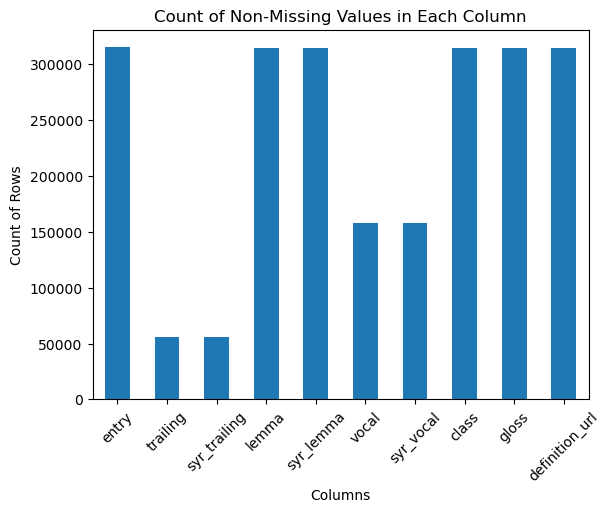

In [92]:
non_missing_values.plot(kind='bar')
plt.title('Count of Non-Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Count of Rows')
plt.xticks(rotation=45)
plt.show()

Redo the NaN and blanks counts, since the categories were reordered and we'd rather see them in the same order as the graph above.

In [94]:
nan_and_blanks = pd.DataFrame(pd.Series(count_nan_and_empty_fields(df))).T
nan_and_blanks

,entry,trailing,syr_trailing,lemma,syr_lemma,vocal,syr_vocal,class,gloss,definition_url
0,0,258687,258687,108,108,156813,156813,220,139,108


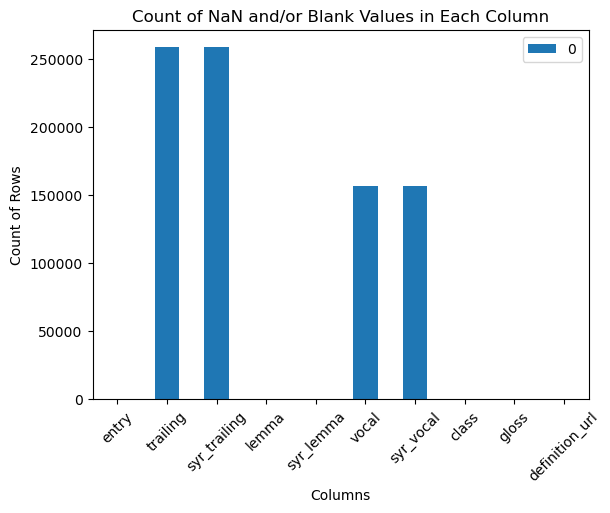

In [95]:
nan_and_blanks.T.plot(kind='bar')
plt.title('Count of NaN and/or Blank Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Count of Rows')
plt.xticks(rotation=45)
plt.show()

In [96]:
# Set the style for all other plots
plt.style.use('default')
sns.set_context("talk")
figsize = (10, 7)

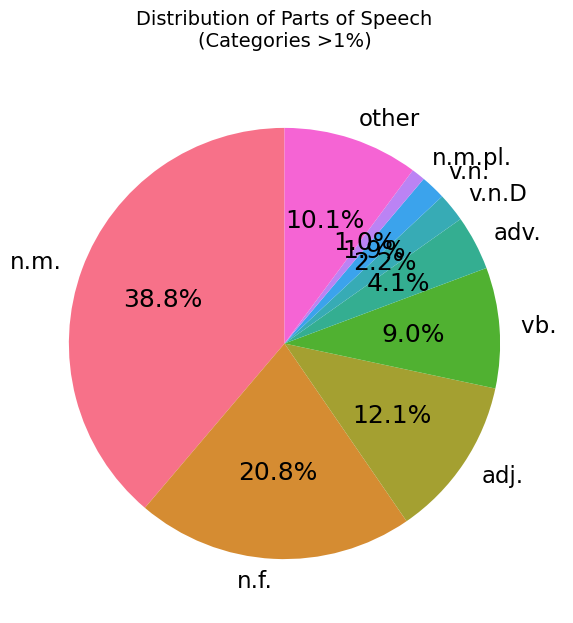

In [100]:
# Parts of Speech Distribution
plt.figure(figsize=figsize)
class_counts = df['class'].value_counts()
major_classes = class_counts[class_counts/len(df) > 0.01]
other_count = class_counts[class_counts/len(df) <= 0.01].sum()
if other_count > 0:
    major_classes['other'] = other_count

colors = sns.color_palette('husl', n_colors=len(major_classes))
plt.pie(major_classes, labels=major_classes.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Distribution of Parts of Speech\n(Categories >1%)', pad=20, size=14)
plt.show()

# Universal style settings
plt.rcParams['figure.figsize'] = figsize
plt.style.use('default')

In [102]:
# Function to create bar charts with consistent styling
def create_bar_chart(data, title, xlabel, ylabel, percentage=False, stacked=False):
    plt.figure(clear=True)
    ax = data.plot(kind='bar', width=0.8, stacked=stacked)
    plt.title(title, pad=20, size=14)
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    # Add extra space at top (20% more than data maximum)
    if percentage:
        plt.ylim(0, 120)  # For percentage plots
    else:
        ymax = data.values.max() if not stacked else data.sum(axis=1).max()
        plt.ylim(0, ymax * 1.2)
    # Adjust legend to never overlap with plot
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    # Add value labels with smaller font
    if stacked:
        for c in ax.containers:
            ax.bar_label(c, fmt='%.0f', label_type='center', fontsize=8)
    else:
        for c in ax.containers:
            ax.bar_label(c, fmt='%.1f%%' if percentage else '%.1f', 
                        padding=3, label_type='edge', fontsize=8)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return ax

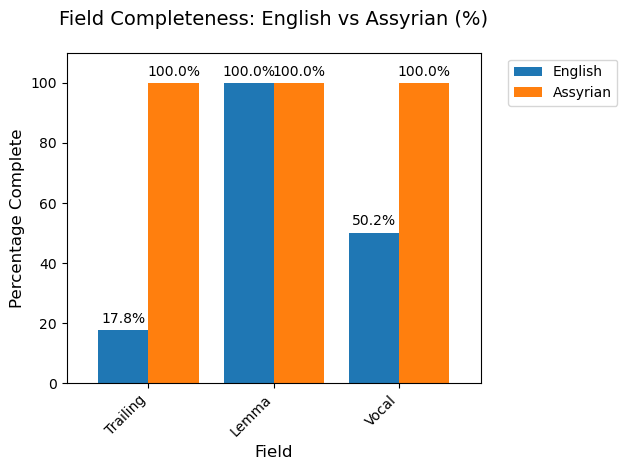

In [104]:
# Completeness comparison between English and Assyrian fields
completeness_comparison = pd.DataFrame({
    'English': [df[col].notna().sum()/len(df)*100 for col in ['trailing', 'lemma', 'vocal']],
    'Assyrian': [df[col].notna().sum()/len(df)*100 for col in ['syr_trailing', 'syr_lemma', 'syr_vocal']]
}, index=['Trailing', 'Lemma', 'Vocal'])
ax = completeness_comparison.plot(kind='bar', width=0.8)
plt.title('Field Completeness: English vs Assyrian (%)', pad=20, size=14)
plt.xlabel('Field', size=12)
plt.ylabel('Percentage Complete', size=12)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

# Label positioning
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, label_type='edge')

plt.ylim(0, 110)  # Give more space at the top for labels
plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

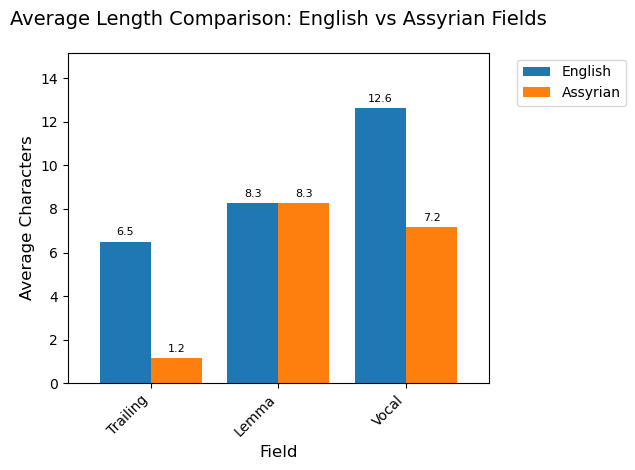

In [105]:
# Average Length Comparison
length_comparison = pd.DataFrame({
    'English': [df[col].str.len().mean() for col in ['trailing', 'lemma', 'vocal']],
    'Assyrian': [df[col].str.len().mean() for col in ['syr_trailing', 'syr_lemma', 'syr_vocal']]
}, index=['Trailing', 'Lemma', 'Vocal'])

create_bar_chart(length_comparison,
                'Average Length Comparison: English vs Assyrian Fields',
                'Field', 'Average Characters')
plt.show()

<Figure size 640x480 with 0 Axes>

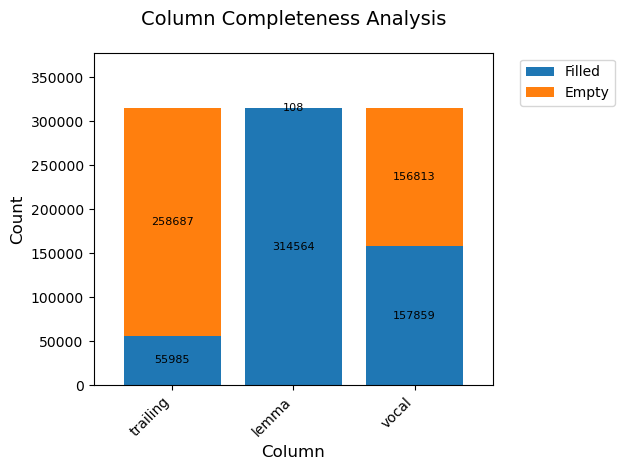

In [108]:
# Column Completeness Analysis
columns_to_check = ['trailing', 'lemma', 'vocal']
completeness_data = pd.DataFrame({
    'Filled': [df[col].notna().sum() for col in columns_to_check],
    'Empty': [df[col].isna().sum() for col in columns_to_check]
}, index=columns_to_check)

create_bar_chart(completeness_data,
                'Column Completeness Analysis',
                'Column', 'Count',
                stacked=True)
plt.show()

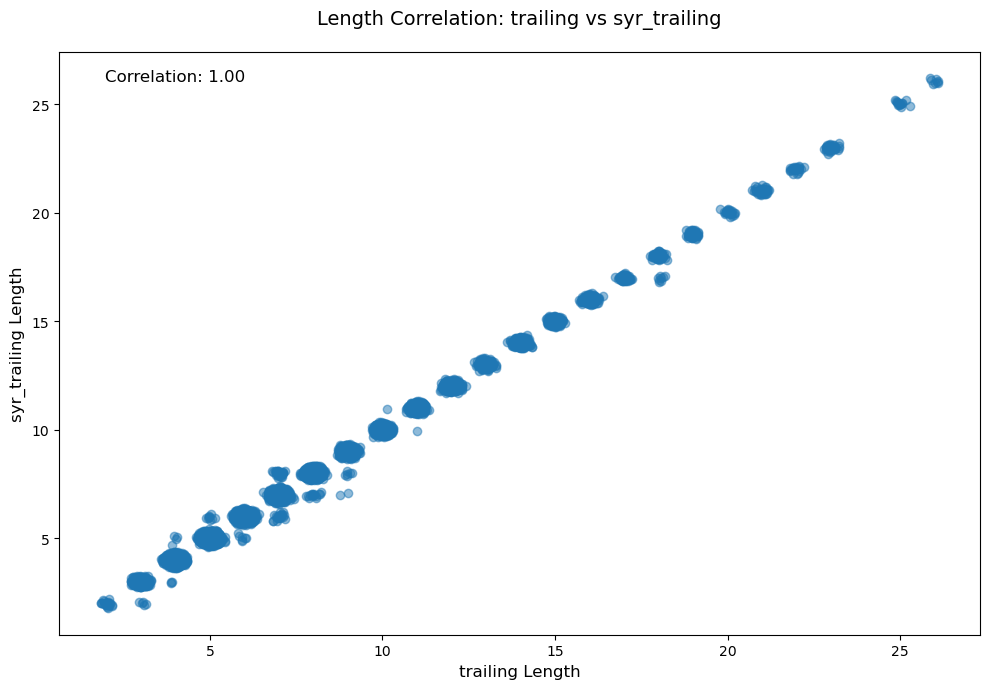

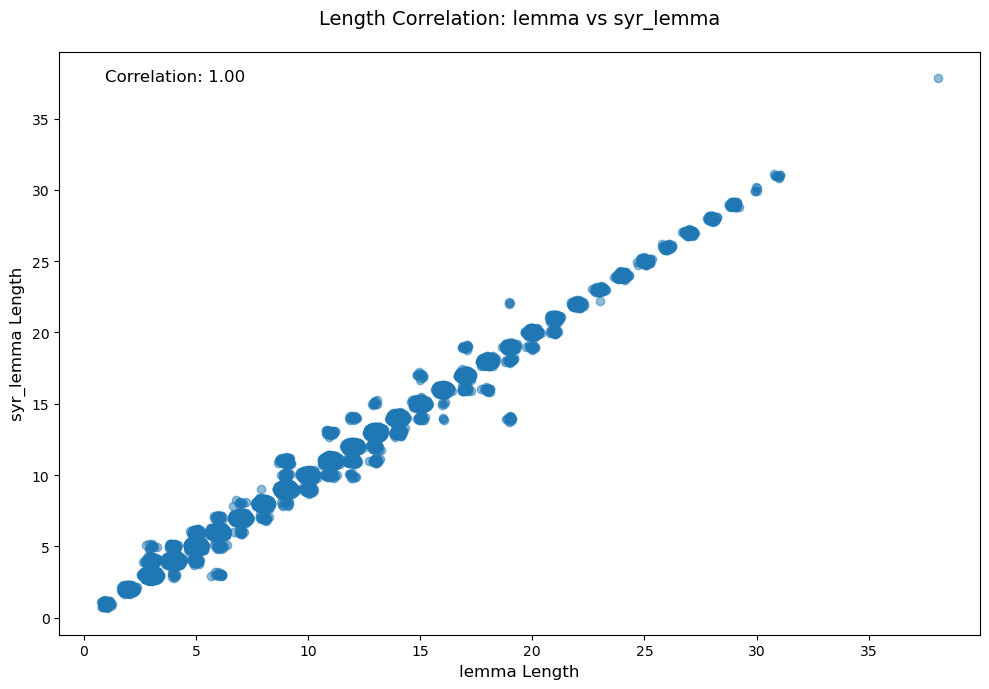

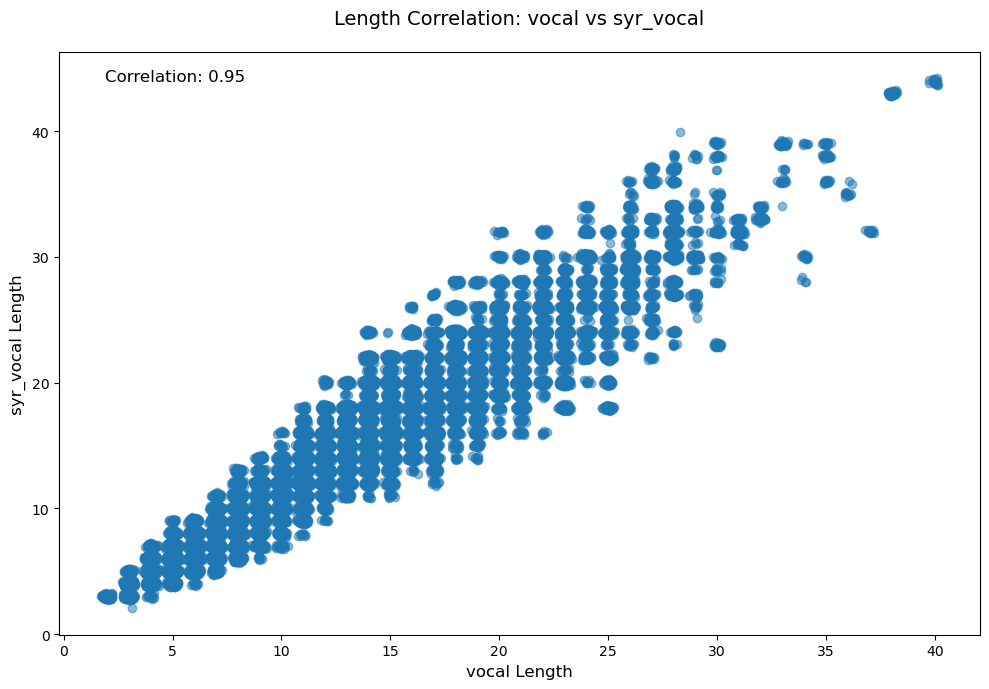

In [116]:
# Correlation between English and Assyrian lengths
for field_pair in [('trailing', 'syr_trailing'), 
                   ('lemma', 'syr_lemma'), 
                   ('vocal', 'syr_vocal')]:
    plt.figure(figsize=figsize)
    # Get lengths for both fields
    eng_lengths = df[field_pair[0]].str.len()
    syr_lengths = df[field_pair[1]].str.len()
    # Create scatter plot with random jitter for better visibility
    plt.scatter(eng_lengths + np.random.normal(0, 0.1, len(eng_lengths)),
                syr_lengths + np.random.normal(0, 0.1, len(syr_lengths)),
                alpha=0.5)
    plt.title(f'Length Correlation: {field_pair[0]} vs {field_pair[1]}', pad=20, size=14)
    plt.xlabel(f'{field_pair[0]} Length', size=12)
    plt.ylabel(f'{field_pair[1]} Length', size=12)
    # Add correlation coefficient
    corr = eng_lengths.corr(syr_lengths)
    plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
             transform=plt.gca().transAxes, size=12)
    plt.tight_layout()
    plt.show()

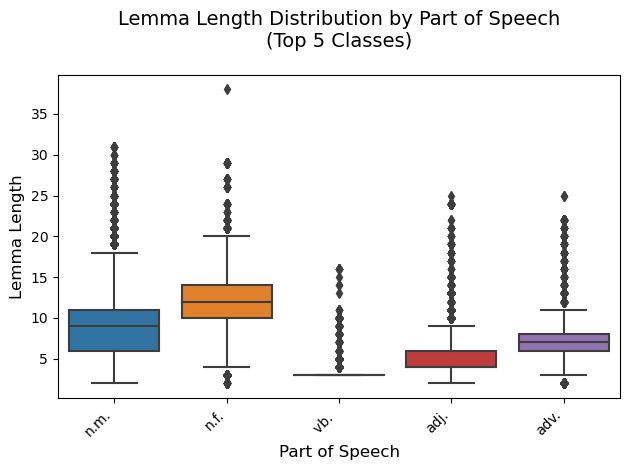

In [120]:
# Word Length Distribution by Part of Speech
df['lemma_length'] = df['lemma'].str.len()
major_classes = df['class'].value_counts().nlargest(5).index

sns.boxplot(data=df[df['class'].isin(major_classes)], 
            x='class', y='lemma_length')
plt.title('Lemma Length Distribution by Part of Speech\n(Top 5 Classes)', pad=20, size=14)
plt.xlabel('Part of Speech', size=12)
plt.ylabel('Lemma Length', size=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

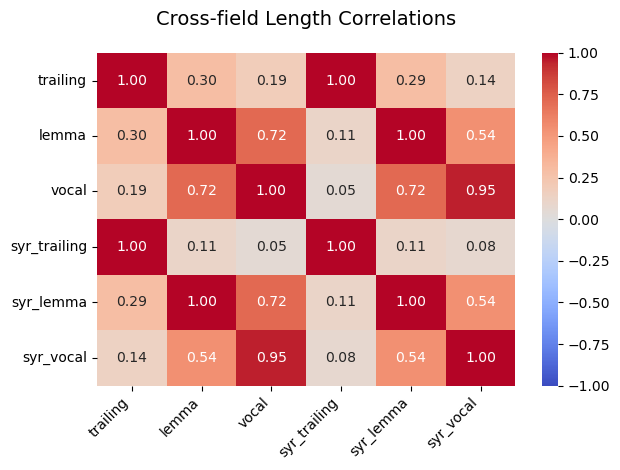

In [124]:
length_columns = ['trailing', 'lemma', 'vocal', 'syr_trailing', 'syr_lemma', 'syr_vocal']
length_df = pd.DataFrame()
for col in length_columns:
    length_df[col] = df[col].str.len()

correlation_matrix = length_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1)
plt.title('Cross-field Length Correlations', pad=20, size=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

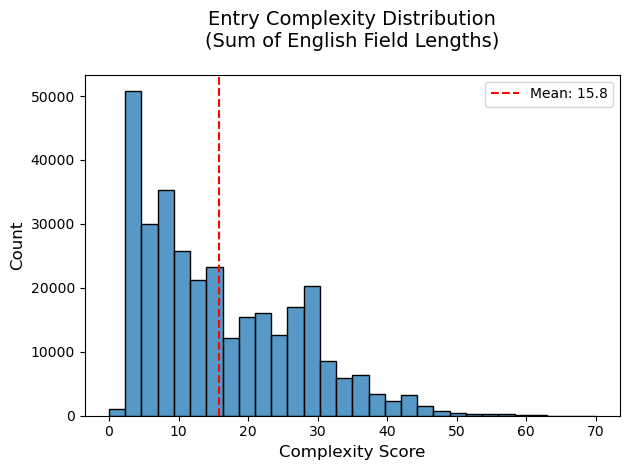

In [126]:
# Entry Complexity Analysis
df['complexity_score'] = (
    df['lemma'].str.len().fillna(0) + 
    df['trailing'].str.len().fillna(0) + 
    df['vocal'].str.len().fillna(0)
)

sns.histplot(data=df, x='complexity_score', bins=30)
plt.axvline(x=df['complexity_score'].mean(), color='r', linestyle='--', 
            label=f'Mean: {df["complexity_score"].mean():.1f}')
plt.title('Entry Complexity Distribution\n(Sum of English Field Lengths)', pad=20, size=14)
plt.xlabel('Complexity Score', size=12)
plt.ylabel('Count', size=12)
plt.legend()
plt.tight_layout()
plt.show()